In [10]:
import nibabel as nib
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm
from tensorflow.keras import layers, models, callbacks, metrics, Input, Model, regularizers
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
import cv2

In [11]:
def calculate_label(image, threshold=0.05):
    """
    Determina o label da subimagem com base no percentual de fundo não-preto.
    :param subimage: Array da subimagem.
    :param threshold: Percentual mínimo de fundo não-preto para considerar como label 1.
    :return: String indicando o label.
    """
    # Total de pixels na subimagem
    total_pixels = image.size
    # Número de pixels não-preto
    non_zero_pixels = np.count_nonzero(image)
    # Proporção de pixels não-preto
    non_black_ratio = non_zero_pixels / total_pixels if total_pixels > 0 else 0
    
    # Verifica se há lesão e se o fundo não-preto é maior que o limiar
    if np.any(image == 1) and non_black_ratio >= threshold:
        return 1
    else:
        return 0

# Função que carrega os dados com pares de imagens
def load_data_with_pairs(folder):
    if not os.path.exists(folder):
        print(f"A pasta {folder} não existe.")
        return {}, {}, {}, {}, {}
    
    images_left = {}
    images_right = {}
    mask_left = {}
    mask_right = {}
    labels_left = {}
    labels_right = {}
    patient_ids = []

    # Itera sobre os pacientes no diretório
    for patient_id in tqdm(os.listdir(folder), desc="Carregamento de arquivos NIfTI..."):
        patient_path = os.path.join(folder, patient_id)

        areas_image = ["left", "right"]
        areas_mask = ["lesion_left", "lesion_right"]
        path_left = os.path.join(patient_path, areas_image[0])
        path_right = os.path.join(patient_path, areas_image[1])
        lesion_path_left = os.path.join(patient_path, areas_mask[0])
        lesion_path_right = os.path.join(patient_path, areas_mask[1])

        if patient_id not in images_left:
            images_left[patient_id] = []
        if patient_id not in images_right:
            images_right[patient_id] = []
        if patient_id not in mask_left:
            mask_left[patient_id] = []
        if patient_id not in mask_right:
            mask_right[patient_id] = []
        if patient_id not in labels_left:
            labels_left[patient_id] = []
        if patient_id not in labels_right:
            labels_right[patient_id] = []
                    
        # Carrega as imagens e máscaras do lado esquerdo
        for patch_id, mask_id in zip(os.listdir(path_left), os.listdir(lesion_path_left)):
            img_path= os.path.join(path_left, patch_id)
            mask_path = os.path.join(lesion_path_left, mask_id)
            for img_path_left, mask_path_left in zip(os.listdir(img_path), os.listdir(mask_path)):
                image_data_left = nib.load(os.path.join(img_path, img_path_left)).get_fdata()
                mask_data_left = nib.load(os.path.join(mask_path, mask_path_left)).get_fdata()

                if (len(image_data_left) > 0 and image_data_left is not []) or (len(mask_data_left) > 0 and mask_data_left is not []):
                    images_left[patient_id].append(image_data_left)
                    mask_left[patient_id].append(mask_data_left)

                    labels_left[patient_id].append(calculate_label(mask_data_left))

        # Carrega as imagens e máscaras do lado direito
        for patch_id, mask_id in zip(os.listdir(path_right), os.listdir(lesion_path_right)):
            img_path = os.path.join(path_right, patch_id)
            mask_path = os.path.join(lesion_path_right, mask_id)
            for img_path_right, mask_path_right in zip(os.listdir(img_path), os.listdir(mask_path)):
                image_data_right = nib.load(os.path.join(img_path, img_path_right)).get_fdata()
                mask_data_right = nib.load(os.path.join(mask_path, mask_path_right)).get_fdata()

                if (len(image_data_right) > 0 and image_data_right is not []) or (len(mask_data_right) > 0 and mask_data_right is not []):
                    images_right[patient_id].append(image_data_right)
                    mask_right[patient_id].append(mask_data_right)
                    
                    labels_right[patient_id].append(calculate_label(mask_data_right))
        patient_ids.append(patient_id)

    # Estruturas para armazenar os pares de labels
    labels_pair = {}
    for patient_id,_ in zip(labels_left.keys(), labels_right.keys()):
        labels_pair[patient_id] = []
        for label_left, label_right in zip(labels_left[patient_id], labels_right[patient_id]): 
            if label_left == 0 and label_right == 0:
                labels_pair[patient_id].append(0)
            else:
                labels_pair[patient_id].append(1)

    print(f"Total de pacientes: {len(patient_ids)}")
    for patient_id, labels in labels_pair.items():
        print(f"Paciente {patient_id}: Total de pares de recortes: {len(labels)}")

    return images_left, images_right, labels_pair, mask_left, mask_right

In [12]:
# Função para normalizar entre 0 e 1
def normalize_minmax(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (data - min_val) / (max_val - min_val)

# Função para filtrar as imagens por paciente
def select_by_patients(patients, all_images_original, all_images_opposite, all_labels):
    selected_images_original = {}
    selected_images_opposite = {}
    selected_labels = []
    
    for patient in patients:
        selected_images_original[patient] = []
        selected_images_opposite[patient] = []
        if patient in all_images_original and patient in all_images_opposite:
            selected_images_original[patient].extend(all_images_original[patient])
            selected_images_opposite[patient].extend(all_images_opposite[patient])
            selected_labels.extend(all_labels[patient])
        else:
            print(f"Paciente {patient} não encontrado em uma das listas de imagens.")
    
    return selected_images_original, selected_images_opposite, selected_labels

In [13]:
# Função para preparar os dados para treino e validação
def prepare_data_for_training_balanced(images_left, images_right, labels_pair, mask_left, mask_right, train_size=0.7, validation_size=0.2, test_size=0.1, augment_factor=1):
    balanced_images_original = {}
    balanced_images_opposite = {}
    balanced_labels = {}
    balanced_mask_original = {}
    balanced_mask_opposite = {}

    for patient_id in images_left:
        class_1_labels = []
        class_0_labels = []
        class_1_left = {}
        class_0_left = {}
        class_1_right = {}
        class_0_right = {}
        class_1_mask_left = {}
        class_0_mask_left = {}
        class_1_mask_right = {}
        class_0_mask_right = {}
        
        class_1_left[patient_id] = []
        class_0_left[patient_id] = []
        class_1_right[patient_id] = []
        class_0_right[patient_id] = []
        class_1_mask_left[patient_id] = []
        class_0_mask_left[patient_id] = []
        class_1_mask_right[patient_id] = []
        class_0_mask_right[patient_id] = []
        index = 0
        
        # Iterar sobre os patches e dividir as classes 0 e 1 com base nas labels\n",
        for label in labels_pair[patient_id]:
            image_left = (images_left[patient_id])[index]
            image_right = (images_right[patient_id])[index]
            mask_image_left = (mask_left[patient_id])[index]
            mask_image_right = (mask_right[patient_id])[index]
            index += 1
            
            if label == 1:
                class_1_labels.append(label)
                class_1_left[patient_id].append(image_left)
                class_1_right[patient_id].append(image_right)
                class_1_mask_left[patient_id].append(mask_image_left)
                class_1_mask_right[patient_id].append(mask_image_right)
            else:
                class_0_labels.append(label)
                class_0_left[patient_id].append(image_left)
                class_0_right[patient_id].append(image_right)
                class_0_mask_left[patient_id].append(mask_image_left)
                class_0_mask_right[patient_id].append(mask_image_right)
        class_1_count = len(class_1_labels)
        print(f"Paciente {patient_id}: Total de pares de recortes com labels 1: {class_1_count}")

        # Fazer undersampling aleatório da classe majoritária (label 0) para igualar ao número de exemplos da classe 1
        class_0_count = len(class_0_labels)
        if class_0_count > class_1_count:
            sampled_indices = np.random.choice(range(class_0_count), class_1_count, replace=False)
            sampled_class_0_slices_left = [class_0_left[patient_id][i] for i in sampled_indices]
            sampled_class_0_slices_right = [class_0_right[patient_id][i] for i in sampled_indices]
            class_0_original_modified = {}
            class_0_original_modified[patient_id] = []
            class_0_opposite_modified = {}
            class_0_opposite_modified[patient_id] = []
            sampled_class_0_mask_left = [class_0_mask_left[patient_id][i] for i in sampled_indices]
            sampled_class_0_mask_right = [class_0_mask_right[patient_id][i] for i in sampled_indices]
            class_0_mask_original_modified = {}
            class_0_mask_original_modified[patient_id] = []
            class_0_mask_opposite_modified = {}
            class_0_mask_opposite_modified[patient_id] = []

            for left_image, left_mask in zip(sampled_class_0_slices_left, sampled_class_0_mask_left):
                class_0_original_modified[patient_id].append(left_image)
                class_0_mask_original_modified[patient_id].append(left_mask)
            for right_image, right_mask in zip(sampled_class_0_slices_right, sampled_class_0_mask_right):
                class_0_opposite_modified[patient_id].append(right_image)
                class_0_mask_opposite_modified[patient_id].append(right_mask)
            class_0_labels = [0] * class_1_count

        balanced_images_original[patient_id] = list(class_1_left[patient_id]) + list(class_0_original_modified[patient_id])
        balanced_images_opposite[patient_id] = list(class_1_right[patient_id]) + list(class_0_opposite_modified[patient_id])
        balanced_labels[patient_id] = class_1_labels + class_0_labels
        balanced_mask_original[patient_id] = list(class_1_mask_left[patient_id]) + list(class_0_mask_original_modified[patient_id])
        balanced_mask_opposite[patient_id] = list(class_1_mask_right[patient_id]) + list(class_0_mask_opposite_modified[patient_id])
    for patient_id, images in balanced_images_original.items():
        print(f"Paciente {patient_id}: Total de pares de recortes (label 1 + label 0): {len(images)}")
        
    # Separar os dados por conjunto (treino, validação, teste)
    patients = list(set(balanced_labels.keys()))
    train_patients, valtest_patients = train_test_split(patients, train_size = train_size)
    valid_patients, test_patients = train_test_split(valtest_patients, train_size = validation_size / (validation_size + test_size))
    
    train_patients = ['sub-00H10', 'sub-14F04', 'sub-16E03',  'sub-19G04', 'sub-22F14', 'sub-25B08', 'sub-26B09', 'sub-31F07', 'sub-35E12', 'sub-36K02', 'sub-41D08', 'sub-42B05', 'sub-44H05', 'sub-51C05', 'sub-52K04', 'sub-56E13', 'sub-59E09', 'sub-59G00', 'sub-60G06', 'sub-60G13',  'sub-71C07', 'sub-72K02', 'sub-76E02', 'sub-76J09', 'sub-79H07', 'sub-83K08', 'sub-85I05', 'sub-86B13']
    valid_patients = ['sub-03C08', 'sub-16I12', 'sub-19F09', 'sub-29D03', 'sub-34J06', 'sub-57D04', 'sub-60K04',  'sub-86G08']
    test_patients = ['sub-02A13', 'sub-16G09', 'sub-42K06', 'sub-72I02']
    
    X_train_original, X_train_opposite, y_train = select_by_patients(train_patients, balanced_images_original, balanced_images_opposite, balanced_labels)
    X_val_original, X_val_opposite, y_val = select_by_patients(valid_patients, balanced_images_original, balanced_images_opposite, balanced_labels)
    X_test_original, X_test_opposite, y_test = select_by_patients(test_patients, balanced_images_original, balanced_images_opposite, balanced_labels)
    mask_test_original, mask_test_opposite, _ = select_by_patients(test_patients, balanced_mask_original, balanced_mask_opposite, balanced_labels)
    
    print(f"Total de pares de recortes no treino ({augment_factor}*{sorted(train_patients)}) com label 1: {y_train.count(1)}")
    print(f"Total de pares de recortes no treino ({augment_factor}*{sorted(train_patients)}) com label 0: {y_train.count(0)}")
    print(f"Total de pares de recortes na validação ({augment_factor}*{sorted(valid_patients)}) com label 1: {y_val.count(1)}")
    print(f"Total de pares de recortes na validação ({augment_factor}*{sorted(valid_patients)}) com label 0: {y_val.count(0)}")
    print(f"Total de pares de recortes no teste com ({augment_factor}*{sorted(test_patients)}) label 1: {y_test.count(1)}")
    print(f"Total de pares de recortes no teste com ({augment_factor}*{sorted(test_patients)}) label 0: {y_test.count(0)}")
    
    return X_train_original, X_train_opposite, X_val_original, X_val_opposite, np.array(y_train), np.array(y_val), train_patients, valid_patients, test_patients

# Função para preparar os dados para teste
def prepare_data_for_training_unbalanced(images_left, images_right, labels_pair, mask_left, mask_right, train_patients, valid_patients, test_patients, train_size=0.7, validation_size=0.2, test_size=0.1, augment_factor=1):
    balanced_images_original = {}
    balanced_images_opposite = {}
    balanced_labels = {}
    balanced_mask_original = {}
    balanced_mask_opposite = {}

    for patient_id in images_left:
        # Lista para armazenar grupos de fatias
        groups = []  
        
        # Criar os grupos de 4 fatias
        for i in range(0, len(labels_pair[patient_id]), 8):
            group = {
                "labels": labels_pair[patient_id][i:i+8],
                "images_left": images_left[patient_id][i:i+8],
                "images_right": images_right[patient_id][i:i+8],
                "mask_left": mask_left[patient_id][i:i+8],
                "mask_right": mask_right[patient_id][i:i+8]
            }
            groups.append(group)

         # Separar grupos com label 1
        class_1_groups = [group for group in groups if 1 in group["labels"]]        
        
        balanced_images_original[patient_id] = []
        balanced_images_opposite[patient_id] = []
        balanced_labels[patient_id] = []
        balanced_mask_original[patient_id] = []
        balanced_mask_opposite[patient_id] = []
        
        for group in class_1_groups:
            balanced_images_original[patient_id].extend(group["images_left"])
            balanced_images_opposite[patient_id].extend(group["images_right"])
            balanced_labels[patient_id].extend(group["labels"])
            balanced_mask_original[patient_id].extend(group["mask_left"])
            balanced_mask_opposite[patient_id].extend(group["mask_right"])
    for patient_id, images in balanced_images_original.items():
        print(f"Paciente {patient_id}: Total de pares de recortes: {len(images)}")
        
    # Separar os dados por conjunto (treino, validação, teste)
    # patients = list(set(balanced_labels.keys()))
    # train_patients, valtest_patients = train_test_split(patients, train_size = train_size)
    # valid_patients, test_patients = train_test_split(valtest_patients, train_size = validation_size / (validation_size + test_size))

    X_train_original, X_train_opposite, y_train = select_by_patients(train_patients, balanced_images_original, balanced_images_opposite, balanced_labels)
    X_val_original, X_val_opposite, y_val = select_by_patients(valid_patients, balanced_images_original, balanced_images_opposite, balanced_labels)
    X_test_original, X_test_opposite, y_test = select_by_patients(test_patients, balanced_images_original, balanced_images_opposite, balanced_labels)
    mask_test_original, mask_test_opposite, _ = select_by_patients(test_patients, balanced_mask_original, balanced_mask_opposite, balanced_labels)

    print(f"Total de pares de recortes no treino ({augment_factor}*{sorted(train_patients)}) com label 1: {y_train.count(1)}")
    print(f"Total de pares de recortes no treino ({augment_factor}*{sorted(train_patients)}) com label 0: {y_train.count(0)}")
    print(f"Total de pares de recortes na validação ({augment_factor}*{sorted(valid_patients)}) com label 1: {y_val.count(1)}")
    print(f"Total de pares de recortes na validação ({augment_factor}*{sorted(valid_patients)}) com label 0: {y_val.count(0)}")
    print(f"Total de pares de recortes no teste com ({augment_factor}*{sorted(test_patients)}) label 1: {y_test.count(1)}")
    print(f"Total de pares de recortes no teste com ({augment_factor}*{sorted(test_patients)}) label 0: {y_test.count(0)}")
    
    return X_train_original, X_train_opposite, X_val_original, X_val_opposite, X_test_original, X_test_opposite, np.array(y_train), np.array(y_val), np.array(y_test), mask_test_original, mask_test_opposite, balanced_images_original, balanced_images_opposite, balanced_mask_original, balanced_mask_opposite

In [14]:
# Função para construir o modelo CNN 2D
def build_cnn_model():
    model = models.Sequential()
    
    model.add(layers.Conv2D(32, (3,3), data_format="channels_last", activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2))) 
    model.add(layers.Dropout(0.4)) 
    
    model.add(layers.Conv2D(64, (3,3), data_format="channels_last", activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2))) 
    model.add(layers.Dropout(0.4))
    
    model.add(layers.Conv2D(128, (3,3), data_format="channels_last", activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2))) 
    model.add(layers.Dropout(0.4))
    
    model.add(layers.Conv2D(256, (3,3), data_format="channels_last", activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.4))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(256, activation='relu'))

    return model

In [15]:
# Função para construir a rede siamesa
def build_siamese_model(input_shape):
    input_original = Input(shape=input_shape)
    input_opposite = Input(shape=input_shape)

    # Criar a CNN base compartilhada
    cnn_base = build_cnn_model()
    
    # Aplicar a mesma CNN base para ambas as entradas
    output_original = cnn_base(input_original)
    output_opposite = cnn_base(input_opposite)

    # Concatenar as duas saídas (Lado esquerdo + Contra-lateral)
    concatenated = layers.Concatenate()([output_original, output_opposite])
    concatenated = layers.BatchNormalization()(concatenated)

    output = layers.Dense(1, activation='sigmoid')(concatenated)
    
    siamese_model = Model(inputs=[input_original, input_opposite], outputs=output)
    siamese_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(name="precision"), metrics.Recall(name="recall")])

    return siamese_model

In [16]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Graphic')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Graphic')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


In [17]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


In [18]:
input_folder = 'Contralateral'

# Carregar os dados
X_left, X_right, y, mask_left, mask_right = load_data_with_pairs(input_folder)

Carregamento de arquivos NIfTI...: 100%|██████████| 40/40 [29:46<00:00, 44.66s/it]

Total de pacientes: 40
Paciente sub-00H10: Total de pares de recortes: 1512
Paciente sub-02A13: Total de pares de recortes: 1512
Paciente sub-03C08: Total de pares de recortes: 1512
Paciente sub-14F04: Total de pares de recortes: 1512
Paciente sub-16E03: Total de pares de recortes: 1512
Paciente sub-16G09: Total de pares de recortes: 1512
Paciente sub-16I12: Total de pares de recortes: 1512
Paciente sub-19F09: Total de pares de recortes: 1512
Paciente sub-19G04: Total de pares de recortes: 1512
Paciente sub-22F14: Total de pares de recortes: 1512
Paciente sub-25B08: Total de pares de recortes: 1512
Paciente sub-26B09: Total de pares de recortes: 1512
Paciente sub-29D03: Total de pares de recortes: 1512
Paciente sub-31F07: Total de pares de recortes: 1512
Paciente sub-34J06: Total de pares de recortes: 1512
Paciente sub-35E12: Total de pares de recortes: 1512
Paciente sub-36K02: Total de pares de recortes: 1512
Paciente sub-41D08: Total de pares de recortes: 1512
Paciente sub-42B05: Tot

In [19]:
# Preparar dados para treino e validação
train_left_balanced, train_right_balanced, valid_left_balanced, valid_right_balanced, y_train_balanced, y_valid_balanced, train_patients, valid_patients, test_patients = prepare_data_for_training_balanced(X_left, X_right, y, mask_left, mask_right, train_size=0.7, validation_size=0.2, test_size=0.1)

# Adiciono camada de cor
train_left_balanced = normalize_minmax(np.array([elemento for lista in train_left_balanced.values() for elemento in lista]))
train_left_balanced = np.expand_dims(train_left_balanced, axis=-1)
train_right_balanced = normalize_minmax(np.array([elemento for lista in train_right_balanced.values() for elemento in lista]))
train_right_balanced = np.expand_dims(train_right_balanced, axis=-1)
valid_left_balanced = normalize_minmax(np.array([elemento for lista in valid_left_balanced.values() for elemento in lista]))
valid_left_balanced = np.expand_dims(valid_left_balanced, axis=-1)
valid_right_balanced = normalize_minmax(np.array([elemento for lista in valid_right_balanced.values() for elemento in lista]))
valid_right_balanced = np.expand_dims(valid_right_balanced, axis=-1)

Paciente sub-00H10: Total de pares de recortes com labels 1: 1
Paciente sub-02A13: Total de pares de recortes com labels 1: 57
Paciente sub-03C08: Total de pares de recortes com labels 1: 37
Paciente sub-14F04: Total de pares de recortes com labels 1: 5
Paciente sub-16E03: Total de pares de recortes com labels 1: 61
Paciente sub-16G09: Total de pares de recortes com labels 1: 44
Paciente sub-16I12: Total de pares de recortes com labels 1: 23
Paciente sub-19F09: Total de pares de recortes com labels 1: 86
Paciente sub-19G04: Total de pares de recortes com labels 1: 12
Paciente sub-22F14: Total de pares de recortes com labels 1: 21
Paciente sub-25B08: Total de pares de recortes com labels 1: 26
Paciente sub-26B09: Total de pares de recortes com labels 1: 85
Paciente sub-29D03: Total de pares de recortes com labels 1: 36
Paciente sub-31F07: Total de pares de recortes com labels 1: 28
Paciente sub-34J06: Total de pares de recortes com labels 1: 41
Paciente sub-35E12: Total de pares de reco

In [20]:
# Construir e compilar o modelo CNN
input_shape = (train_left_balanced[0].shape)

siamese_model = build_siamese_model(input_shape)
siamese_model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 50, 1)]          0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 50, 50, 1)]          0         []                            
                                                                                                  
 sequential (Sequential)     (None, 256)                  455552    ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 concatenate (Concatenate)   (None, 512)                  0         ['sequential[0][0]',    

In [21]:
# Adicionar o callback EarlyStopping e low rate scheduler
# early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Salvar a melhor epoca
checkpoint = callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss',  save_best_only=True,  save_weights_only=True, mode='min')

# Ajusta learning rate
reduce_lr = callbacks.ReduceLROnPlateau(factor=0.2, patience=5, verbose=1)

# Treinamento do modelo siames
history = siamese_model.fit([train_left_balanced, train_right_balanced], y_train_balanced, validation_data=([valid_left_balanced, valid_right_balanced], y_valid_balanced), batch_size=128, epochs=150, callbacks=[checkpoint, reduce_lr])

Epoch 1/150


19/19 [==============================] - 11s 339ms/step - loss: 0.7406 - accuracy: 0.6174 - precision: 0.6175 - recall: 0.6170 - val_loss: 0.7259 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - lr: 0.0010
Epoch 2/150
19/19 [==============================] - 5s 288ms/step - loss: 0.6319 - accuracy: 0.6841 - precision: 0.6729 - recall: 0.7166 - val_loss: 0.7491 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - lr: 0.0010
Epoch 3/150
19/19 [==============================] - 5s 276ms/step - loss: 0.6305 - accuracy: 0.6713 - precision: 0.6653 - recall: 0.6895 - val_loss: 0.8960 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - lr: 0.0010
Epoch 4/150
19/19 [==============================] - 5s 275ms/step - loss: 0.6041 - accuracy: 0.6825 - precision: 0.6799 - recall: 0.6895 - val_loss: 1.0137 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - lr: 0.0010
Epoch 5/150
19/19 [==========================

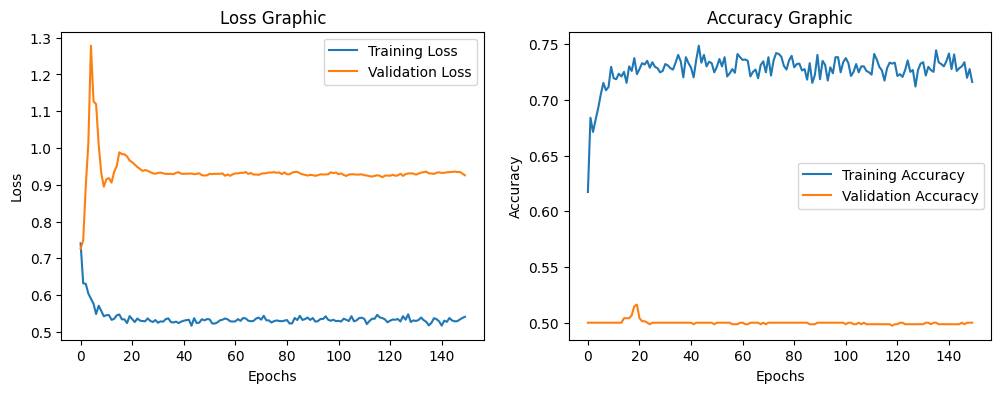

In [22]:
# Plotar o histórico do treinamento
plot_training_history(history)

In [23]:
# Preparar dados para teste e predição
X_train_left, X_train_right, X_valid_left, X_valid_right, X_test_left, X_test_right, y_train, y_valid, y_test, mask_left_test, mask_right_test, images_left_by_patient, images_right_by_patient, mask_left_by_patient, mask_right_by_patient = prepare_data_for_training_unbalanced(X_left, X_right, y, mask_left, mask_right, train_patients, valid_patients, test_patients, train_size=0.7, validation_size=0.2, test_size=0.1)

# Crio copias para o print em pdf
train_left = X_train_left
train_right = X_train_right
valid_left = X_valid_left
valid_right = X_valid_right
test_left = X_test_left
test_right = X_test_right

# Adiciono camada de cor
X_train_left = normalize_minmax(np.array([elemento for lista in X_train_left.values() for elemento in lista]))
X_train_left = np.expand_dims(X_train_left, axis=-1)
X_train_right = normalize_minmax(np.array([elemento for lista in X_train_right.values() for elemento in lista]))
X_train_right = np.expand_dims(X_train_right, axis=-1)
X_valid_left = normalize_minmax(np.array([elemento for lista in X_valid_left.values() for elemento in lista]))
X_valid_left = np.expand_dims(X_valid_left, axis=-1)
X_valid_right = normalize_minmax(np.array([elemento for lista in X_valid_right.values() for elemento in lista]))
X_valid_right = np.expand_dims(X_valid_right, axis=-1)
X_test_left = normalize_minmax(np.array([elemento for lista in X_test_left.values() for elemento in lista]))
X_test_left = np.expand_dims(X_test_left, axis=-1)
X_test_right = normalize_minmax(np.array([elemento for lista in X_test_right.values() for elemento in lista]))
X_test_right = np.expand_dims(X_test_right, axis=-1)

Paciente sub-00H10: Total de pares de recortes: 8
Paciente sub-02A13: Total de pares de recortes: 344
Paciente sub-03C08: Total de pares de recortes: 192
Paciente sub-14F04: Total de pares de recortes: 40
Paciente sub-16E03: Total de pares de recortes: 288
Paciente sub-16G09: Total de pares de recortes: 208
Paciente sub-16I12: Total de pares de recortes: 184
Paciente sub-19F09: Total de pares de recortes: 416
Paciente sub-19G04: Total de pares de recortes: 96
Paciente sub-22F14: Total de pares de recortes: 168
Paciente sub-25B08: Total de pares de recortes: 208
Paciente sub-26B09: Total de pares de recortes: 352
Paciente sub-29D03: Total de pares de recortes: 288
Paciente sub-31F07: Total de pares de recortes: 120
Paciente sub-34J06: Total de pares de recortes: 328
Paciente sub-35E12: Total de pares de recortes: 208
Paciente sub-36K02: Total de pares de recortes: 176
Paciente sub-41D08: Total de pares de recortes: 368
Paciente sub-42B05: Total de pares de recortes: 232
Paciente sub-42K

35/35 [==============================] - 1s 20ms/step


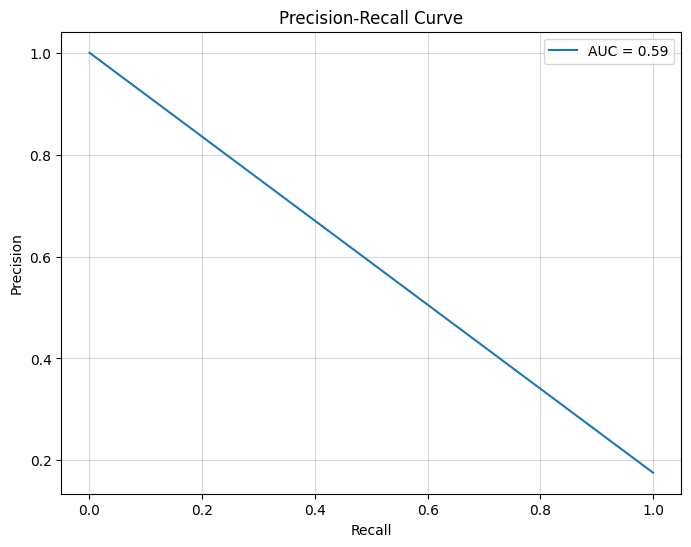

In [24]:
# Carregando pesos da melhor época
siamese_model.load_weights('best_model.h5')

# Avaliar o modelo no treino
y_pred_train = (siamese_model.predict([X_train_left, X_train_right]) >= 0.7)

# Avaliar o modelo na validação
y_pred_valid = (siamese_model.predict([X_valid_left, X_valid_right]) >= 0.7)

# Avaliar o modelo no teste
y_pred_test = (siamese_model.predict([X_test_left, X_test_right]) >= 0.7)

# Calcula a curva precision-recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_test)

# Calcula a AUC precision-recall
auc_pr = auc(recall, precision)

# Plote a curva precision-recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUC = {auc_pr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(alpha=0.5)
plt.show()

In [25]:
# Gerar o relatório de classificação
print("Validação:")
print(classification_report(y_valid, y_pred_valid))
print("\n#########################################################\n")
print("Teste:")
print(classification_report(y_test, y_pred_test)) 

Validação:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      1910
           1       0.00      0.00      0.00       370

    accuracy                           0.84      2280
   macro avg       0.42      0.50      0.46      2280
weighted avg       0.70      0.84      0.76      2280


#########################################################

Teste:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       910
           1       0.00      0.00      0.00       194

    accuracy                           0.82      1104
   macro avg       0.41      0.50      0.45      1104
weighted avg       0.68      0.82      0.74      1104



c:\Users\Gabriel Panza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gabriel Panza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gabriel Panza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

Validação:


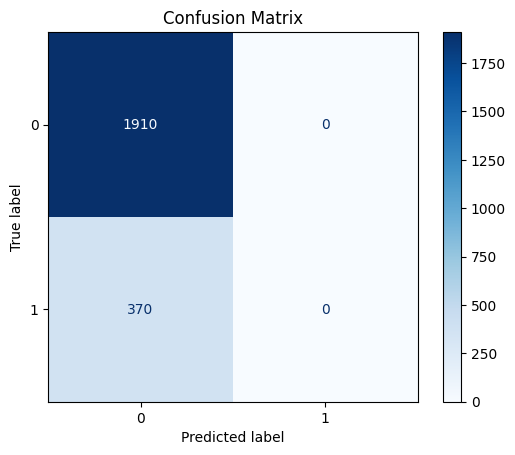


#########################################################

Teste:


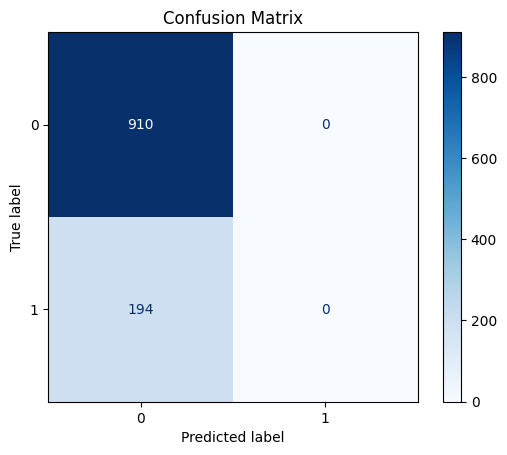

In [26]:
# Gerar a matriz de confusão
print("Validação:")
plot_confusion_matrix(y_valid, y_pred_valid)
print("\n#########################################################\n")
print("Teste:")
plot_confusion_matrix(y_test, y_pred_test)

In [27]:
def add_border(image, color, thickness=3):
    """
    Adiciona uma borda colorida ao redor de uma imagem, convertendo para RGB se necessário.
    
    Args:
        image (numpy.ndarray): Imagem original em escala de cinza.
        color (tuple): Cor da borda (RGB).
        thickness (int): Espessura da borda.

    Returns:
        numpy.ndarray: Imagem com a borda adicionada em formato RGB.
    """
    # Normalizar a imagem para o intervalo 0-255
    image_normalized = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    # Converter para RGB
    if len(image_normalized.shape) == 2:  # Se a imagem for escala de cinza
        image_rgb = cv2.cvtColor(image_normalized, cv2.COLOR_GRAY2RGB)
    else:
        image_rgb = image_normalized

    # Adicionar a borda
    bordered_image = cv2.copyMakeBorder(
        image_rgb, 
        thickness, thickness, thickness, thickness, 
        cv2.BORDER_CONSTANT, 
        value=color
    )
    
    return bordered_image


def build_image(img, mask, classificacao):
    # Tamanho dos patches
    patch_size = 56

    # Inicializar a matriz para a imagem e a máscara reconstruídas
    imagem_reconstruida = np.zeros((4 * patch_size, 4 * patch_size, 3), dtype=np.uint8)
    mascara_reconstruida = np.zeros((4 * patch_size, 4 * patch_size, 3), dtype=np.uint8)

    # Mapear os patches para as posições corretas na matriz com bordas baseadas na classificação
    colors = {"TP": (0, 255, 0), "TN": (0, 255, 0), "FP": (255, 0, 0), "FN": (255, 255, 0)}  # RGB: Vermelho, Verde, Azul

    # Ordem correta para reconstrução
    correct_order = [
        0, 1, 8, 9,    # Linha 1
        2, 3, 10, 11,   # Linha 2
        4, 5, 12, 13,  # Linha 3
        6, 7, 14, 15   # Linha 4
    ]
    correct_order_classification = [
        0, 1, 1, 0,    # Linha 1
        2, 3, 3, 2,    # Linha 2
        4, 5, 5, 4,    # Linha 3
        6, 7, 7, 6     # Linha 4
    ]

    # Loop para reconstruir as linhas e colunas
    for i in range(4):  # Linha
        for j in range(4):  # Coluna
            idx = correct_order[i * 4 + j]
            idx_classification = correct_order_classification[i * 4 + j]
            x_start = i * patch_size
            y_start = j * patch_size
            
            # Adicionar bordas às imagens
            imagem_reconstruida[x_start:x_start + patch_size, y_start:y_start + patch_size, :] = add_border(img[idx], colors[classificacao[idx_classification]])
            mascara_reconstruida[x_start:x_start + patch_size, y_start:y_start + patch_size, :] = add_border(mask[idx], colors[classificacao[idx_classification]])
    
    return imagem_reconstruida, mascara_reconstruida


In [28]:
def plot_patient_slices(pdf_filename, patients, images_left, images_right, mask_left, mask_right, labels_true, labels_pred):
    """
    Gera um PDF com imagens de pacientes e suas máscaras.

    Args:
        pdf_filename (str): Nome do arquivo PDF.
        patients (list): Lista de IDs dos pacientes.
        images_dict (dict): Dicionário com imagens completas dos pacientes.
        masks_dict (dict): Dicionário com máscaras completas dos pacientes.
        labels_true (list): Labels verdadeiros das fatias.
        labels_pred (list): Labels preditos das fatias.
        slice_limits (list): Limites de fatias por paciente.
        non_black_threshold (float): Limite para considerar pixels não pretos.
        min_percentage_non_black (float): Porcentagem mínima de pixels não pretos para exibir.
    """
    with PdfPages(pdf_filename) as pdf:
        for patient in patients:
            cont = 0            
            
            classificacao = []
            vetor_left_img = []
            vetor_left_mask = []
            vetor_right_img = []
            vetor_right_mask = []
            tmp_vetor_left_img = []
            tmp_vetor_left_mask = []
            tmp_vetor_right_img = []
            tmp_vetor_right_mask = []
            tmp_classificacao = []
            
            for img_left, img_right, msk_left, msk_right in zip(images_left[patient], images_right[patient], mask_left[patient], mask_right[patient]):
                tmp_vetor_left_img.append(img_left)
                tmp_vetor_left_mask.append(msk_left)
                tmp_vetor_right_img.append(np.fliplr(img_right))
                tmp_vetor_right_mask.append(np.fliplr(msk_right))
                if labels_pred[cont] == 1:
                    if labels_true[cont] == 1:
                        tmp_classificacao.append("TP")
                    else:
                        if (calculate_label(msk_left) or calculate_label(msk_right)):
                            tmp_classificacao.append("TP")
                        else:
                            tmp_classificacao.append("FP")
                elif labels_pred[cont] == 0:
                    if labels_true[cont] == 1:
                        if (calculate_label(msk_left) or calculate_label(msk_right)):
                            tmp_classificacao.append("FN")
                        else:
                            tmp_classificacao.append("TN")
                    else:
                        tmp_classificacao.append("TN")
                
                cont+=1
                if cont%8 ==0:
                    vetor_left_img.append(tmp_vetor_left_img)
                    vetor_left_mask.append(tmp_vetor_left_mask)
                    vetor_right_img.append(tmp_vetor_right_img)
                    vetor_right_mask.append(tmp_vetor_right_mask)
                    classificacao.append(tmp_classificacao)
                    tmp_vetor_left_img = []
                    tmp_vetor_left_mask = []
                    tmp_vetor_right_img = []
                    tmp_vetor_right_mask = []
                    tmp_classificacao = []
            
            cont = 0
            for i in range(len(vetor_left_img)):
                imagem_reconstruida, mascara_reconstruida = build_image(vetor_left_img[i]+vetor_right_img[i], vetor_left_mask[i]+vetor_right_mask[i], classificacao[i])
                if (np.any(imagem_reconstruida) == 1):    
                    # Configurar a figura
                    fig, axs = plt.subplots(2, 1, figsize=(4, 4))

                    axs[0].imshow(np.flipud(imagem_reconstruida), cmap='gray')
                    axs[0].set_title(f'{patient}')
                    axs[0].axis('off')
                    axs[1].imshow(np.flipud(mascara_reconstruida), cmap='gray')
                    axs[1].axis('off')
                    
                    # Adicionar ao PDF
                    pdf.savefig(fig)
                    plt.close(fig)
        
        print(f"As imagens foram salvas no arquivo PDF {pdf_filename} com sucesso.")

# Processar Treino
plot_patient_slices(
    pdf_filename="Pdf_SNN/Pacientes_Train_Reconstruidos.pdf",
    patients=train_patients,
    images_left=images_left_by_patient,
    images_right=images_right_by_patient,
    mask_left=mask_left_by_patient,
    mask_right=mask_right_by_patient,
    labels_true=y_train,
    labels_pred=y_pred_train
)

# Processar Validação
plot_patient_slices(
    pdf_filename="Pdf_SNN/Pacientes_Valid_Reconstruidos.pdf",
    patients=valid_patients,
    images_left=images_left_by_patient,
    images_right=images_right_by_patient,
    mask_left=mask_left_by_patient,
    mask_right=mask_right_by_patient,
    labels_true=y_valid,
    labels_pred=y_pred_valid
)

# Processar Teste
plot_patient_slices(
    pdf_filename="Pdf_SNN/Pacientes_Test_Reconstruidos.pdf",
    patients=test_patients,
    images_left=images_left_by_patient,
    images_right=images_right_by_patient,
    mask_left=mask_left_by_patient,
    mask_right=mask_right_by_patient,
    labels_true=y_test,
    labels_pred=y_pred_test
)

As imagens foram salvas no arquivo PDF Pdf_SNN/Pacientes_Train_Reconstruidos.pdf com sucesso.
As imagens foram salvas no arquivo PDF Pdf_SNN/Pacientes_Valid_Reconstruidos.pdf com sucesso.
As imagens foram salvas no arquivo PDF Pdf_SNN/Pacientes_Test_Reconstruidos.pdf com sucesso.
